In [1]:
!git clone https://github.com/mkeohane01/object_detection

Cloning into 'object_detection'...
remote: Enumerating objects: 677, done.
remote: Counting objects: 100% (677/677), done.
remote: Compressing objects: 100% (513/513), done.
remote: Total 677 (delta 13), reused 672 (delta 11), pack-reused 0
Receiving objects: 100% (677/677), 18.44 MiB | 8.90 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-w1y7jbjw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-w1y7jbjw
  Resolved https://github.com/facebookresearch/detectron2.git to commit cc9266c2396d5545315e3601027ba4bc28e8c95b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6120610 sha256=c5b4e17ed13c1af665b0826d0e4

In [28]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import random
import os
import json
import torch
import cv2
from google.colab.patches import cv2_imshow

### Register Data

In [4]:
!pwd

/content/object_detection


In [7]:
def clean_file_paths_in_json(json_file_path, save_to_new_file=False):
    # Load the JSON data
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    # Iterate through each entry and clean the file_name
    for item in data:
        if 'file_name' in item:
            item['file_name'] = item['file_name'].replace('\\', '/')

    # Save the cleaned data back to the JSON file
    if save_to_new_file:
        new_file_path = json_file_path.replace('.json', '_cleaned.json')
    else:
        new_file_path = json_file_path

    with open(new_file_path, 'w') as file:
        json.dump(data, file, indent=4)

    return new_file_path

json_file_path = 'data/dataset_dict_train.json'  # Update this path
new_file_path = clean_file_paths_in_json(json_file_path, save_to_new_file=True)
print(f"Cleaned JSON saved to: {new_file_path}")

Cleaned JSON saved to: data/dataset_dict_train_cleaned.json


In [8]:
classes = ['drink', 'laptop', 'utensil']
for d in ["train", "val", "test"]:
    dict_path = os.path.join("data",f"dataset_dict_{d}_cleaned.json")
    with open(dict_path) as f:
        dataset_dicts = json.load(f)
    print(d)
    DatasetCatalog.register("dataset_" + d, lambda d=d: dataset_dicts)
    MetadataCatalog.get("dataset_" + d).set(thing_classes=classes)
    print("DatasetCatalog registered")
    print("MetadataCatalog set")

train
DatasetCatalog registered
MetadataCatalog set
val
DatasetCatalog registered
MetadataCatalog set
test
DatasetCatalog registered
MetadataCatalog set


data/yolo-data/images/test/IMG_7524_JPG.rf.b5afd6bf4b65af1fae465151d5f9eacd.jpg


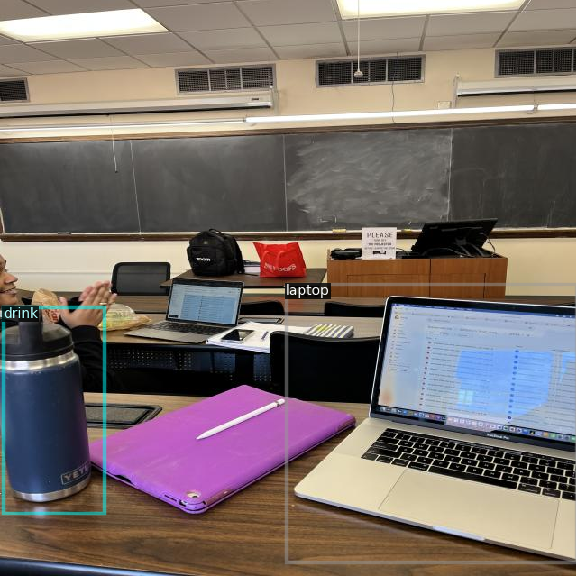

data/yolo-data/images/test/IMG_7089_jpeg.rf.79e5798aea24b3742fbc126a883c0259.jpg


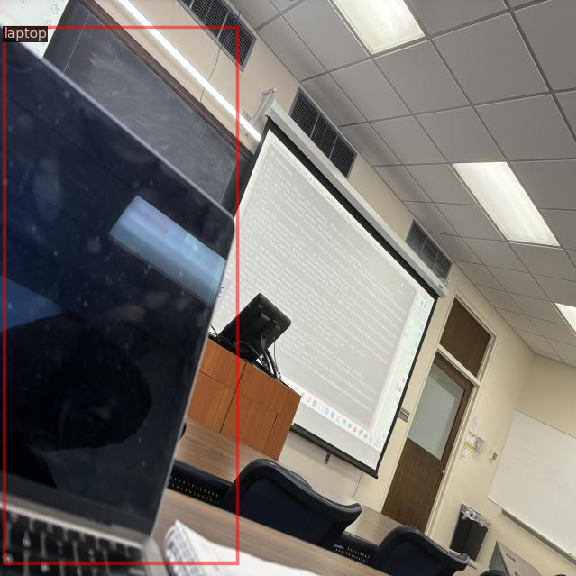

data/yolo-data/images/test/IMG_7097_jpeg.rf.457d2b8f2949e17f4aa01eff2ab069c7.jpg


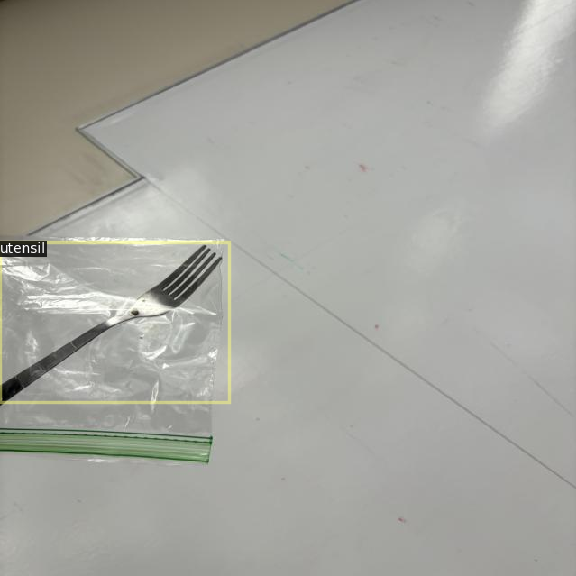

data/yolo-data/images/test/IMG_4222_JPG.rf.2e615b94d1e7e8e320604670e53b065f.jpg


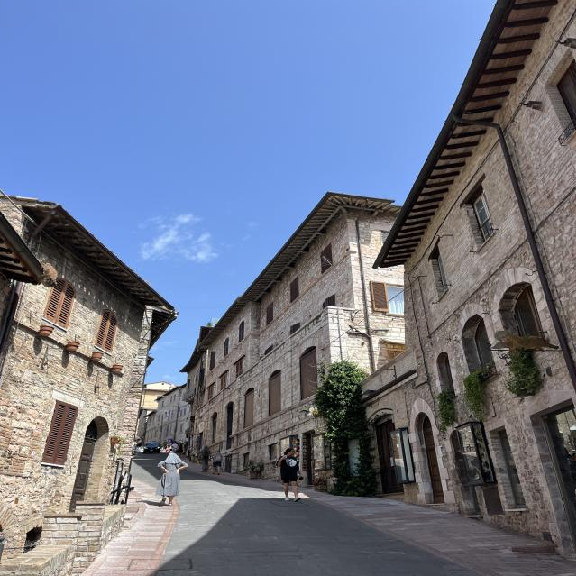

data/yolo-data/images/test/62F3FB9D-9407-4078-B3BF-F7FE042DB01A_1_105_c_jpeg.rf.99c56e38ef3df4b6eea8d28acc3825dd.jpg


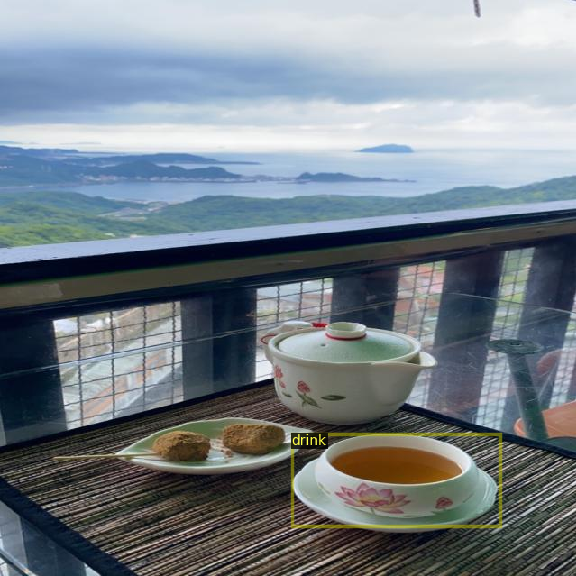

data/yolo-data/images/test/72160113485__3B77DF3E-D3EB-4C44-95EC-59417F0AFC40_jpeg.rf.a60718e1774c8a2c55b65c00843f6094.jpg


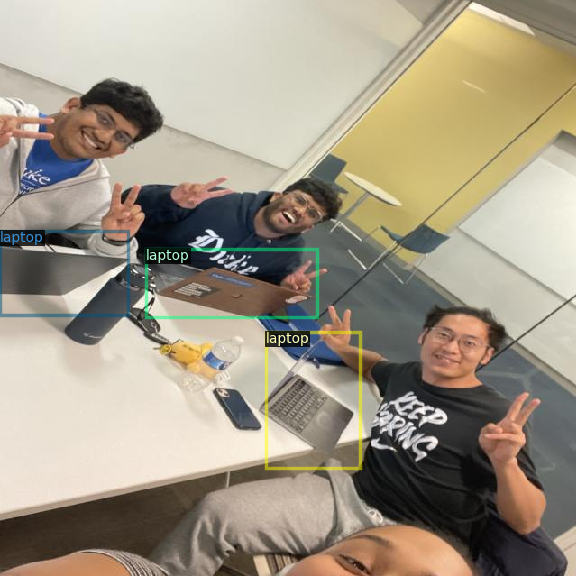

In [11]:
dataset_train_metadata = MetadataCatalog.get("dataset_train")
dataset_dicts = DatasetCatalog.get("dataset_train")

for d in random.sample(dataset_dicts, 6):
    path = d["file_name"]
    print(path)
    img = cv2.imread(os.path.normpath(path))
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_train_metadata, scale=0.9)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train Model

In [24]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ("dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.OUTPUT_DIR = "./output2"
# Link to the model weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 5000

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3

# Freeze the backbone layers
cfg.MODEL.BACKBONE.FREEZE_AT = 2

print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('dataset_val',)
  TRAIN: ('dataset_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res

In [13]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_optimizer(cls, cfg, model):
        """
        Custom function to build the optimizer, allowing us to exclude
        certain parameters from the optimizer (thus freezing them)
        """
        frozen_parameters = set()
        for name, parameter in model.named_parameters():
            if "backbone" in name:  # Freeze layers by adjusting this condition
                frozen_parameters.add(name)
                parameter.requires_grad_(False)

        params = []
        for key, value in model.named_parameters():
            if key not in frozen_parameters and value.requires_grad:
                params.append({"params": [value]})
        optimizer = torch.optim.SGD(params, lr=cfg.SOLVER.BASE_LR, momentum=cfg.SOLVER.MOMENTUM)
        return optimizer

In [3]:
os.chdir("./object_detection")
!pwd

/content/object_detection


In [25]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/12 21:08:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/12 21:08:48 d2.engine.train_loop]: Starting training from iteration 0
[03/12 21:08:52 d2.utils.events]:  eta: 0:14:19  iter: 19  total_loss: 2.406  loss_cls: 1.422  loss_box_reg: 1.031  loss_rpn_cls: 0.02345  loss_rpn_loc: 0.006578    time: 0.1747  last_time: 0.1926  data_time: 0.0265  last_data_time: 0.0123   lr: 4.9952e-05  max_mem: 810M
[03/12 21:08:56 d2.utils.events]:  eta: 0:14:24  iter: 39  total_loss: 1.944  loss_cls: 0.9403  loss_box_reg: 0.9575  loss_rpn_cls: 0.02943  loss_rpn_loc: 0.01118    time: 0.1778  last_time: 0.1831  data_time: 0.0110  last_data_time: 0.0137   lr: 9.9902e-05  max_mem: 810M
[03/12 21:08:59 d2.utils.events]:  eta: 0:14:25  iter: 59  total_loss: 1.638  loss_cls: 0.7101  loss_box_reg: 0.8867  loss_rpn_cls: 0.01898  loss_rpn_loc: 0.005405    time: 0.1789  last_time: 0.1915  data_time: 0.0113  last_data_time: 0.0052   lr: 0.00014985  max_mem: 810M
[03/12 21:09:03 d2.utils.events]:  eta: 0:14:17  iter: 79  total_loss: 1.584  loss_cls: 0.6186  loss_box_re

## Evaluation

In [32]:
cfg.MODEL.WEIGHTS = os.path.join("./output2/", "model_0004999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("dataset_test", cfg, False, output_dir="./output5/")
val_loader = build_detection_test_loader(cfg, "dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[03/12 22:00:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output2/model_0004999.pth ...
WARNING [03/12 22:00:38 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/12 22:00:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/12 22:00:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/12 22:00:38 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[03/12 22:00:38 d2.data.common]: Serialized dataset takes 0.02 MiB
[03/12 22:00:38 d2.evaluation.evaluator]: Start inference on 50 batches
[03/12 22:00:39 d2.evaluation.evaluator]: Inference done 11/50. Dataloading: 0.0015 s/iter. Inference: 0.0847 s/iter. Eval: 0.0003 s/iter. Total: 0.0865 s/iter. ETA=0:0

OrderedDict([('bbox',
              {'AP': 80.27612330926468,
               'AP50': 100.0,
               'AP75': 98.37004108574122,
               'APs': nan,
               'APm': 77.27722772277228,
               'APl': 80.6188100033387,
               'AP-drink': 81.34858760890278,
               'AP-laptop': 79.64694931031565,
               'AP-utensil': 79.83283300857559})])